In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from matplotlib.pyplot import grid
from scipy.stats import alpha

In [4]:
path = os.path.join('../../Data/Combined/master.geojson')
data = gpd.read_file(path)
data.head()

,CCN,REPORT_DAT,START_DATE,END_DATE,BLOCK,OFFENSE,METHOD,SHIFT,WARD,ANC,...,total_housing_units,median_household_income,poverty_rate,unemployment_rate,pct_bachelors_or_higher,pct_renter_occupied,vacancy_rate,pct_non_hispanic_black,pct_hispanic_latino,geometry
0,25061371,2025-04-27 22:57:54+00:00,2025-04-27 19:02:00+00:00,NaT,2206 - 2399 BLOCK OF RHODE ISLAND AVENUE NE,THEFT/OTHER,OTHERS,EVENING,5,5C,...,2011.0,85913.0,0.209428,0.080241,0.276028,0.391845,0.077573,0.700702,0.145236,POINT (-8568585.274 4711741.573)
1,25423133,2025-08-07 15:01:39+00:00,2025-08-01 09:25:00+00:00,2025-08-01 10:25:00+00:00,1500 - 1530 BLOCK OF PARK ROAD NW,THEFT/OTHER,OTHERS,DAY,1,1A,...,2769.0,82675.0,0.343769,0.064027,0.401737,0.772481,0.023113,0.159968,0.460513,POINT (-8575542.479 4711829.687)
2,25423282,2025-08-11 15:31:58+00:00,2025-06-21 18:00:00+00:00,2025-06-21 18:00:00+00:00,500 - 599 BLOCK OF 12TH STREET NW,THEFT/OTHER,OTHERS,DAY,2,2C,...,1664.0,151659.0,0.093492,0.025826,0.794421,0.563101,0.178486,0.108471,0.193182,POINT (-8574727.566 4706891.978)
3,25424175,2025-09-27 12:31:47+00:00,2025-09-27 08:55:00+00:00,2025-09-27 09:10:00+00:00,201 - 298 BLOCK OF FLORIDA AVENUE NW,THEFT/OTHER,OTHERS,DAY,5,5E,...,1409.0,109250.0,0.117211,0.022255,0.325668,0.524485,0.132718,0.434471,0.106083,POINT (-8573229.845 4709242.487)
4,25062541,2025-04-29 23:47:22+00:00,2025-04-15 22:49:00+00:00,2025-04-15 23:28:00+00:00,2000 - 2099 BLOCK OF L STREET NW,THEFT/OTHER,OTHERS,EVENING,2,2A,...,1517.0,101786.0,0.127427,0.033374,0.686286,0.605142,0.174687,0.037015,0.138956,POINT (-8576696.489 4707893.932)


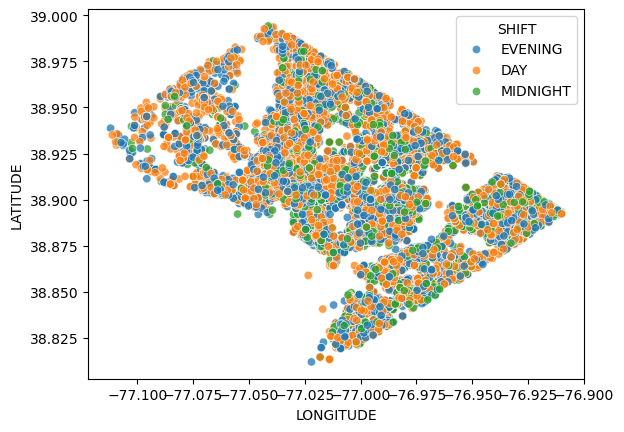

In [11]:
sns.scatterplot(data=data,
                x='LONGITUDE',
                y='LATITUDE',
                hue='SHIFT',
                alpha =0.75,
                grid = True,

                )
plt.show()